In [1]:
using Revise, BeamPropagation, Distributions, StatsBase, StaticArrays, PhysicalConstants.CODATA2018, Plots, BenchmarkTools

┌ Info: Precompiling BeamPropagation [3b7771b3-0fff-45f6-8d8e-6a934b658944]
└ @ Base loading.jl:1278
┌ Warning: Package BeamPropagation does not have LoopVectorization in its dependencies:
│ - If you have BeamPropagation checked out for development and have
│   added LoopVectorization as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with BeamPropagation
└ Loading LoopVectorization into BeamPropagation from project dependency, future warnings for BeamPropagation are suppressed.


In [2]:
const vz_μ = @with_unit 50 "m/s"
const vz_σ = @with_unit 20 "m/s"
const vxy_μ = @with_unit 0 "m/s"
const vxy_σ = @with_unit 20 "m/s"
const exit_radius = @with_unit 4 "mm"
;

In [3]:
const r = (
    Normal(0, exit_radius/2), 
    Normal(0, exit_radius/2), 
    Normal(0, 0)
)
const a = (
    Normal(0, 0), 
    Normal(0, 0), 
    Normal(0, 0)
)
;

In [14]:
n            = Int64(1e8)
dt           = 1e-3 
delete_every = 15
max_steps    = Int64(3.5e4)
;

In [15]:
@inline discard(r, v) = false
;

In [16]:
function f(i, particle, dt, p, s)
        
    aperture = p.apertures[i]
    
    r = particle.r
    rad = sqrt(r[1]^2 + r[2]^2)
    dead = rad > (aperture[2] / 2)
    return (particle.state, particle.v, particle.a, dead)
end
;

In [17]:
using StructArrays
;

In [18]:
signals = [
    4.1676
    4.0794
    4.3809
    4.4672
    4.9664
    5.3245
    6.0337
    6.2169
    7.5252
    8.6727
    9.7792
   10.9273
   13.1498
   15.0915
   15.3065
   19.0722
   23.2966
   25.3869
   30.3813
   33.7240
   35.8383
   43.4540
   38.9792
   37.5734
   31.9527
   25.0429
   18.0709
   12.8811
    8.3424
    5.4059
    4.2137
]
vzs = 
[
  253.8000
  245.3400
  236.8800
  228.4200
  219.9600
  211.5000
  203.0400
  194.5800
  186.1200
  177.6600
  169.2000
  160.7400
  152.2800
  143.8200
  135.3600
  126.9000
  118.4400
  109.9800
  101.5200
   93.0600
   84.6000
   76.1400
   67.6800
   59.2200
   50.7600
   42.3000
   33.8400
   25.3800
   16.9200
    8.4600
         0
]
;

In [19]:
# We define limiting apertures as (z position, aperture diameter)
apertures = [
    (0.005, 1.000) # 5 mm outside the cell
    (0.070, 0.010)
    (0.200, 0.035) # middle of KF40 nipple
#     (0.265, 0.035) # end of KF40 nipple, 65 mm down from its center
#     (0.580, 0.040) # detecting at 58 cm, limiting aperture is from the blackened box
]
p = @params (apertures,)
;

In [46]:
# Function to convert from forward velocity to σ for transverse velocity
# See the file `analysis_03222021_CaAbsorptionDopplerOutsideCell.m` for details on how this fit was attained
function vz_to_σxy(vz)
    offset = 1e3 * (0.05 / vz)
    a = 10.88
    b = -0.5 #-0.762
    c = 37.61 + 40
    return a * offset ^ b + c
end

vz_to_σxy (generic function with 1 method)

In [47]:
vz_to_σxy(100)

92.99664355861927

In [50]:
counts = zeros(length(vzs))

for (i, vz) in enumerate(vzs)

    vxy_σ_ = vz_to_σxy(vz)
    v = (
        Normal(vxy_μ, vxy_σ_),
        Normal(vxy_μ, vxy_σ_),
        Normal(vz, 0)
    )
    display(v)
    
    m = round(Int64, n * signals[i] / sum(signals) )
    ts = [aperture[1] / vz for aperture in apertures]
    
    particles = StructArray{Particle}(undef, m)
    propagate_particles!(dt, r, v, a, particles, f, 1, discard, delete_every, max_steps, p, 1, ts)
    
    counts[i] = sum( abs.([r[2] for r in particles.r]) .< 0.001 )
    
end

(Normal{Float64}(μ=0.0, σ=102.12261826896507), Normal{Float64}(μ=0.0, σ=102.12261826896507), Normal{Float64}(μ=253.8, σ=0.0))

(Normal{Float64}(μ=0.0, σ=101.7106121482422), Normal{Float64}(μ=0.0, σ=101.7106121482422), Normal{Float64}(μ=245.34, σ=0.0))

(Normal{Float64}(μ=0.0, σ=101.29143909140659), Normal{Float64}(μ=0.0, σ=101.29143909140659), Normal{Float64}(μ=236.88, σ=0.0))

(Normal{Float64}(μ=0.0, σ=100.86471154325505), Normal{Float64}(μ=0.0, σ=100.86471154325505), Normal{Float64}(μ=228.42, σ=0.0))

(Normal{Float64}(μ=0.0, σ=100.43000570727361), Normal{Float64}(μ=0.0, σ=100.43000570727361), Normal{Float64}(μ=219.96, σ=0.0))

(Normal{Float64}(μ=0.0, σ=99.986856615709), Normal{Float64}(μ=0.0, σ=99.986856615709), Normal{Float64}(μ=211.5, σ=0.0))

(Normal{Float64}(μ=0.0, σ=99.53475230236364), Normal{Float64}(μ=0.0, σ=99.53475230236364), Normal{Float64}(μ=203.04, σ=0.0))

(Normal{Float64}(μ=0.0, σ=99.07312687005322), Normal{Float64}(μ=0.0, σ=99.07312687005322), Normal{Float64}(μ=194.58, σ=0.0))

(Normal{Float64}(μ=0.0, σ=98.60135218512615), Normal{Float64}(μ=0.0, σ=98.60135218512615), Normal{Float64}(μ=186.12, σ=0.0))

(Normal{Float64}(μ=0.0, σ=98.11872785133198), Normal{Float64}(μ=0.0, σ=98.11872785133198), Normal{Float64}(μ=177.66, σ=0.0))

(Normal{Float64}(μ=0.0, σ=97.62446900619649), Normal{Float64}(μ=0.0, σ=97.62446900619649), Normal{Float64}(μ=169.2, σ=0.0))

(Normal{Float64}(μ=0.0, σ=97.11769133239503), Normal{Float64}(μ=0.0, σ=97.11769133239503), Normal{Float64}(μ=160.74, σ=0.0))

(Normal{Float64}(μ=0.0, σ=96.59739246552829), Normal{Float64}(μ=0.0, σ=96.59739246552829), Normal{Float64}(μ=152.28, σ=0.0))

(Normal{Float64}(μ=0.0, σ=96.06242867917392), Normal{Float64}(μ=0.0, σ=96.06242867917392), Normal{Float64}(μ=143.82, σ=0.0))

(Normal{Float64}(μ=0.0, σ=95.5114852925672), Normal{Float64}(μ=0.0, σ=95.5114852925672), Normal{Float64}(μ=135.36, σ=0.0))

(Normal{Float64}(μ=0.0, σ=94.94303860262245), Normal{Float64}(μ=0.0, σ=94.94303860262245), Normal{Float64}(μ=126.9, σ=0.0))

(Normal{Float64}(μ=0.0, σ=94.35530616978978), Normal{Float64}(μ=0.0, σ=94.35530616978978), Normal{Float64}(μ=118.44, σ=0.0))

(Normal{Float64}(μ=0.0, σ=93.74618078232888), Normal{Float64}(μ=0.0, σ=93.74618078232888), Normal{Float64}(μ=109.98, σ=0.0))

(Normal{Float64}(μ=0.0, σ=93.11314102883671), Normal{Float64}(μ=0.0, σ=93.11314102883671), Normal{Float64}(μ=101.52, σ=0.0))

(Normal{Float64}(μ=0.0, σ=92.45312747637774), Normal{Float64}(μ=0.0, σ=92.45312747637774), Normal{Float64}(μ=93.06, σ=0.0))

(Normal{Float64}(μ=0.0, σ=91.76236675612952), Normal{Float64}(μ=0.0, σ=91.76236675612952), Normal{Float64}(μ=84.6, σ=0.0))

(Normal{Float64}(μ=0.0, σ=91.0361139694254), Normal{Float64}(μ=0.0, σ=91.0361139694254), Normal{Float64}(μ=76.14, σ=0.0))

(Normal{Float64}(μ=0.0, σ=90.26826164368552), Normal{Float64}(μ=0.0, σ=90.26826164368552), Normal{Float64}(μ=67.68, σ=0.0))

(Normal{Float64}(μ=0.0, σ=89.4507195457033), Normal{Float64}(μ=0.0, σ=89.4507195457033), Normal{Float64}(μ=59.22, σ=0.0))

(Normal{Float64}(μ=0.0, σ=88.57237615118183), Normal{Float64}(μ=0.0, σ=88.57237615118183), Normal{Float64}(μ=50.76, σ=0.0))

(Normal{Float64}(μ=0.0, σ=87.61723450309825), Normal{Float64}(μ=0.0, σ=87.61723450309825), Normal{Float64}(μ=42.3, σ=0.0))

(Normal{Float64}(μ=0.0, σ=86.5607426462836), Normal{Float64}(μ=0.0, σ=86.5607426462836), Normal{Float64}(μ=33.84, σ=0.0))

(Normal{Float64}(μ=0.0, σ=85.36157051441835), Normal{Float64}(μ=0.0, σ=85.36157051441835), Normal{Float64}(μ=25.38, σ=0.0))

(Normal{Float64}(μ=0.0, σ=83.93913082184275), Normal{Float64}(μ=0.0, σ=83.93913082184275), Normal{Float64}(μ=16.92, σ=0.0))

(Normal{Float64}(μ=0.0, σ=82.0853713231418), Normal{Float64}(μ=0.0, σ=82.0853713231418), Normal{Float64}(μ=8.46, σ=0.0))

(Normal{Float64}(μ=0.0, σ=77.61), Normal{Float64}(μ=0.0, σ=77.61), Normal{Float64}(μ=0.0, σ=0.0))

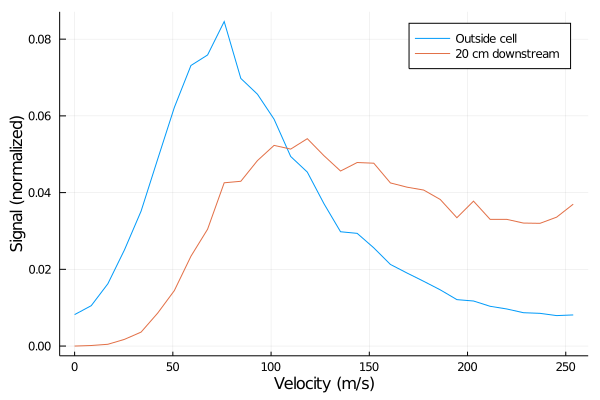

In [51]:
plot(vzs, signals ./ sum(signals), label="Outside cell")
plot!(vzs, counts ./ sum(counts), label="20 cm downstream")
xlabel!("Velocity (m/s)")
ylabel!("Signal (normalized)")